# **Examen Final — Punto 1: Procesamiento de Imágenes (Oso de Anteojos)**


Este notebook contiene todo lo requerido para el Punto 1 del examen final. 


## **Requisitos**

In [19]:
pip install opencv-python-headless imageio scikit-image matplotlib numpy


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import color, filters, morphology, exposure
import cv2

## **1. Carga y visualización de una imagen (RGB) de un animal en via de extinción**

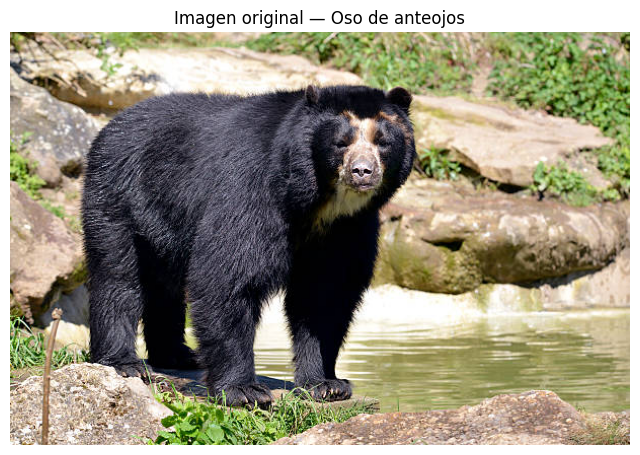

In [21]:
IMAGE_PATH = "data/bear.jpg"


bgr = cv2.imread(str(IMAGE_PATH))
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(8,6))
plt.imshow(rgb)
plt.axis('off')
plt.title('Imagen original — Oso de anteojos')
plt.show()

## **2. Filtros básicos**

Se aplicaran:

- Suavizado (Gaussian blur)
- Realce de bordes: Unsharp mask y Sobel (bordes)

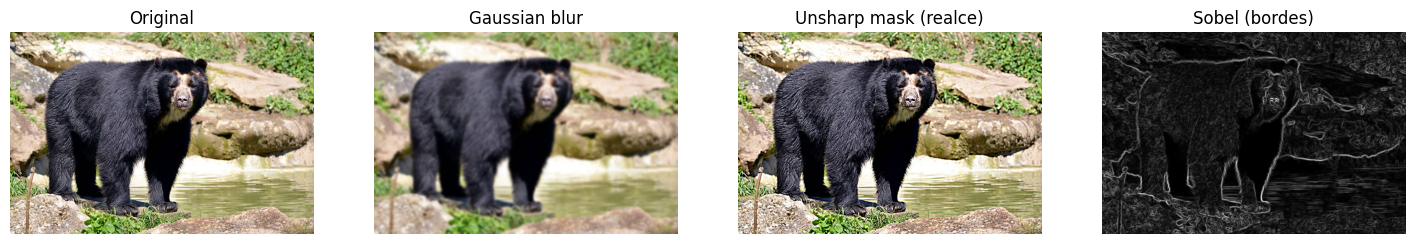

In [22]:
# Suavizado: Gaussian blur
gauss = cv2.GaussianBlur(rgb, ksize=(11,11), sigmaX=0)


# Suavizado: Median (como alternativa)
median = cv2.medianBlur(rgb, ksize=7)


# Realce de bordes: Unsharp masking
# unsharp = original + amount * (original - blurred)
blurred_for_unsharp = cv2.GaussianBlur(rgb, (9,9), 10)
unsharp = cv2.addWeighted(rgb, 1.5, blurred_for_unsharp, -0.5, 0)


# Bordes con Sobel (grayscale -> sobel -> mostrar como overlay)
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
sobel = np.hypot(sobelx, sobely)
sobel = (sobel / sobel.max() * 255).astype(np.uint8)


# Mostrar resultados
fig, axes = plt.subplots(1,4, figsize=(18,6))
axes[0].imshow(rgb); axes[0].set_title('Original'); axes[0].axis('off')
axes[1].imshow(gauss); axes[1].set_title('Gaussian blur'); axes[1].axis('off')
axes[2].imshow(unsharp); axes[2].set_title('Unsharp mask (realce)'); axes[2].axis('off')
axes[3].imshow(sobel, cmap='gray'); axes[3].set_title('Sobel (bordes)'); axes[3].axis('off')
plt.show()

- En el Suavizado (Gaussian blur / median): reduce ruido y detalles finos — el pelaje y textura pierden definición, útil para eliminar pequeñas variaciones de iluminación.
- Con el Realce de bordes (Unsharp mask): aumenta contraste local y hace que los contornos (ojos, nariz, borde del pelaje) se noten más nítidos.
- COn Sobel se muestra dónde hay cambios abruptos de intensidad (bordes). Resaltando contornos y texturas fuertes.

## **3. Visualización de canales de color**

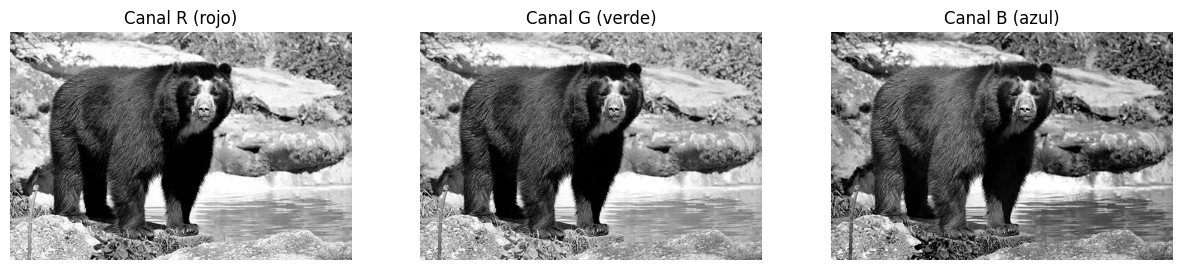

In [23]:
R = rgb[:,:,0]
G = rgb[:,:,1]
B = rgb[:,:,2]


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(R, cmap='gray'); axes[0].set_title('Canal R (rojo)'); axes[0].axis('off')
axes[1].imshow(G, cmap='gray'); axes[1].set_title('Canal G (verde)'); axes[1].axis('off')
axes[2].imshow(B, cmap='gray'); axes[2].set_title('Canal B (azul)'); axes[2].axis('off')
plt.show()


### **Breve explicación (qué se ve más claro/oscuro en cada canal):**
- Canal R: superficies y objetos con componentes rojos (ej. partes marrones del pelaje, tierra, hojas secas) aparecen más brillantes. Zonas con baja componente roja (césped verde intenso) aparecen más oscuras.
- Canal G: resalta la vegetación y áreas con tonalidades verdes; el pelaje marrón puede verse de intensidad media.
- Canal B: suele mostrar más contraste en sombras y cielos (si los hay). Para animales con pelaje marrón/negro, el canal azul suele ser más oscuro en las zonas de pelaje y más claro en reflejos fríos o en el fondo.

## **4. Operaciones morfológicas**

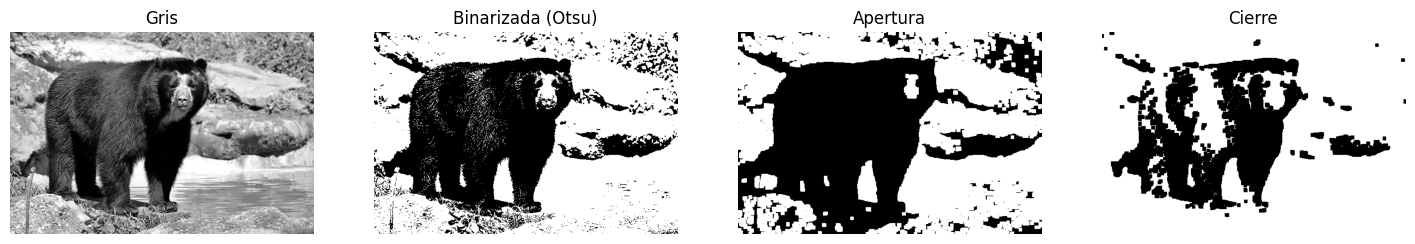

In [24]:
# Escala de grises
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

# Binarización por Otsu
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Estructurante (kernel)
kernel = np.ones((7,7), np.uint8)

# Operación 1: Apertura (erosión seguida de dilatación) -> elimina pequeños objetos/ruido
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Operación 2: Cierre (dilatación seguida de erosión) -> rellena huecos pequeños en objetos
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# Mostrar comparativo
fig, axes = plt.subplots(1,4, figsize=(18,6))
axes[0].imshow(gray, cmap='gray'); axes[0].set_title('Gris'); axes[0].axis('off')
axes[1].imshow(binary, cmap='gray'); axes[1].set_title('Binarizada (Otsu)'); axes[1].axis('off')
axes[2].imshow(opening, cmap='gray'); axes[2].set_title('Apertura'); axes[2].axis('off')
axes[3].imshow(closing, cmap='gray'); axes[3].set_title('Cierre'); axes[3].axis('off')
plt.show()

### **Explicación breve de las operaciones morfológicas realizadas:**

- Apertura: elimina pequeñas regiones blancas aisladas (ruido) y suaviza los contornos de los objetos grandes. En la imagen del oso podría reducir puntos brillantes o texturas pequeñas en el fondo.
- Cierre: rellena pequeños agujeros o zonas oscuras dentro de regiones claras; ayuda a conectar partes fragmentadas de un objeto.

## **5. Animación**

Se generaran 2 GIFs:

- filters.gif: secuencia [original -> gaussian -> unsharp -> sobel]
- morphs.gif: secuencia [binarizada -> apertura -> cierre]

In [25]:
gif_filters_path = 'gifs/filters.gif'
gif_morph_path = 'gifs/morphs.gif'

# Función 1: Generar GIF de filtros 
def generar_gif_filtros(rgb, gauss, unsharp, sobel, salida):
    frames = []

    # Solo 1 frame por etapa (la duración la controla el GIF)
    def rep(x, n=1):
        return [x] * n

    sobel_rgb = np.stack([sobel] * 3, axis=2)

    frames += rep(rgb)        # 4 segundos
    frames += rep(gauss)      # 4 segundos
    frames += rep(unsharp)    # 4 segundos
    frames += rep(sobel_rgb)  # 4 segundos

    # Cada frame dura 4 segundos
    imageio.mimsave(str(salida), frames, duration=4.0)


# Función 2: Generar GIF de morfología 
def generar_gif_morfologia(rgb, binary, opening, closing, salida):
    frames = []

    def rep(x, n=1):
        return [x] * n

    # Convertir grayscale o binarizadas a RGB 
    def to_rgb(img):
        return np.stack([img] * 3, axis=2) if img.ndim == 2 else img

    frames += rep(rgb)             # 4 segundos
    frames += rep(to_rgb(binary))  # 4 segundos
    frames += rep(to_rgb(opening)) # 4 segundos
    frames += rep(to_rgb(closing)) # 4 segundos

    imageio.mimsave(str(salida), frames, duration=4.0)


# ---- Generación de los GIFs ----

generar_gif_filtros(
    rgb,
    gauss,
    unsharp,
    sobel,
    gif_filters_path
)

generar_gif_morfologia(
    rgb,
    binary,
    opening,
    closing,
    gif_morph_path
)

print("GIFs generados correctamente:")
print(" -", gif_filters_path)
print(" -", gif_morph_path)


GIFs generados correctamente:
 - gifs/filters.gif
 - gifs/morphs.gif
